In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPool2D, BatchNormalization, Flatten,
    Dropout, Dense
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.initializers import GlorotNormal


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
dataset_path = '/content/drive/MyDrive/chest_xray'

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path + "/train",
    image_size =(64, 64),
    batch_size = 32,
    label_mode ="binary"
)

Found 2369 files belonging to 2 classes.


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path + "/train",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(64, 64),
    batch_size=64,
    label_mode="binary"
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path + "/train",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(64, 64),
    batch_size=64,
    label_mode="binary"
)

Found 2369 files belonging to 2 classes.
Using 1896 files for training.
Found 2369 files belonging to 2 classes.
Using 473 files for validation.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path + '/test',
    image_size = (64, 64),
    batch_size = 32,
    label_mode = "binary"
)

Found 632 files belonging to 2 classes.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.data import Dataset
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPool2D, BatchNormalization, Flatten, Dropout, Dense, Input)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import (
    TruePositives, FalsePositives, TrueNegatives, FalseNegatives,
    BinaryAccuracy, Precision, Recall, AUC, SpecificityAtSensitivity
)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve



In [ ]:
train_ds = train_ds.shuffle(1000).prefetch(tf.data.AUTOTUNE)
validation_ds = validation_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
from os import name
# Define performance metrics
METRICS = [
    TruePositives(name = 'tp'),
    FalsePositives(name='fp'),
    TrueNegatives(name='tn'),
    FalseNegatives(name='fn'),
    BinaryAccuracy (name = 'accuracy'),
    Precision (name = 'precision'),
    Recall (name= 'recall'),
    AUC (name= 'auc'),
    SpecificityAtSensitivity (name ='sensitivity', sensitivity = 0.8),
]

def build_model(filters, input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(filters[0], (5, 5), padding='same', kernel_regularizer=l2(0.001), activation=relu)(inputs)
    x = Conv2D(filters[1], (3, 3), padding='same', kernel_regularizer=l2(0.001), activation=relu)(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, kernel_initializer=GlorotNormal(), activation=sigmoid)(x)

    model = Model(inputs, outputs)  # Ensure this is the only return value
    return model  # ✅ Return only the model (not a tuple)


In [ ]:
model = build_model([128, 64], (64, 64, 3))  # Updated input shape format
model.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(learning_rate=1e-3, beta_1=0.92, beta_2=0.999),
    metrics=METRICS
)

In [ ]:
# Early stopping callback
early_callback = EarlyStopping(
    monitor='val_auc',
    patience =10,
    mode ='vax',
    verbose =1,
    restore_best_weights= True
)

<ipython-input-11-c9620893ef88>:2: UserWarning: EarlyStopping mode vax is unknown, fallback to auto mode.
  early_callback = EarlyStopping(


In [ ]:
# Train the model
history = model.fit(
    train_ds,
    epochs=60,
    validation_data=validation_ds,
    callbacks=[early_callback]
)


Epoch 1/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 291s 5s/step - accuracy: 0.8176 - auc: 0.8454 - fn: 81.4194 - fp: 67.0968 - loss: 0.9819 - precision: 0.7582 - recall: 0.7176 - sensitivity: 0.7005 - tn: 576.9677 - tp: 294.9032 - val_accuracy: 0.7378 - val_auc: 0.7250 - val_fn: 124.0000 - val_fp: 0.0000e+00 - val_loss: 3.9167 - val_precision: 1.0000 - val_recall: 0.3111 - val_sensitivity: 0.0137 - val_tn: 293.0000 - val_tp: 56.0000
Epoch 2/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 163s 4s/step - accuracy: 0.9481 - auc: 0.9848 - fn: 28.3548 - fp: 22.1290 - loss: 0.2386 - precision: 0.9344 - recall: 0.9178 - sensitivity: 0.9902 - tn: 607.4839 - tp: 343.8387 - val_accuracy: 0.9345 - val_auc: 0.9843 - val_fn: 4.0000 - val_fp: 27.0000 - val_loss: 0.3747 - val_precision: 0.8670 - val_recall: 0.9778 - val_sensitivity: 0.9795 - val_tn: 266.0000 - val_tp: 176.0000
Epoch 3/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 199s 4s/step - accuracy: 0.9404 - auc: 0.9838 - fn: 27.6774 - fp: 28.1613 - loss: 0.2650 - precision: 0.9199 - recall:

In [ ]:
model.save('model_base.keras')

In [ ]:
# Function to plot training loss
def plot_log_loss(history, title_label):
  plt.figure(figsize=(10, 6))
  plt.semilogy(history.epoch, history.history['loss'], label ='Train'+ title_label)
  plt.semilogy(history.epoch, history.history['val_loss'], label ='Val'+ title_label)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Loss Curve')
  plt.show

  plot_log_loss(history, 'Model Base')

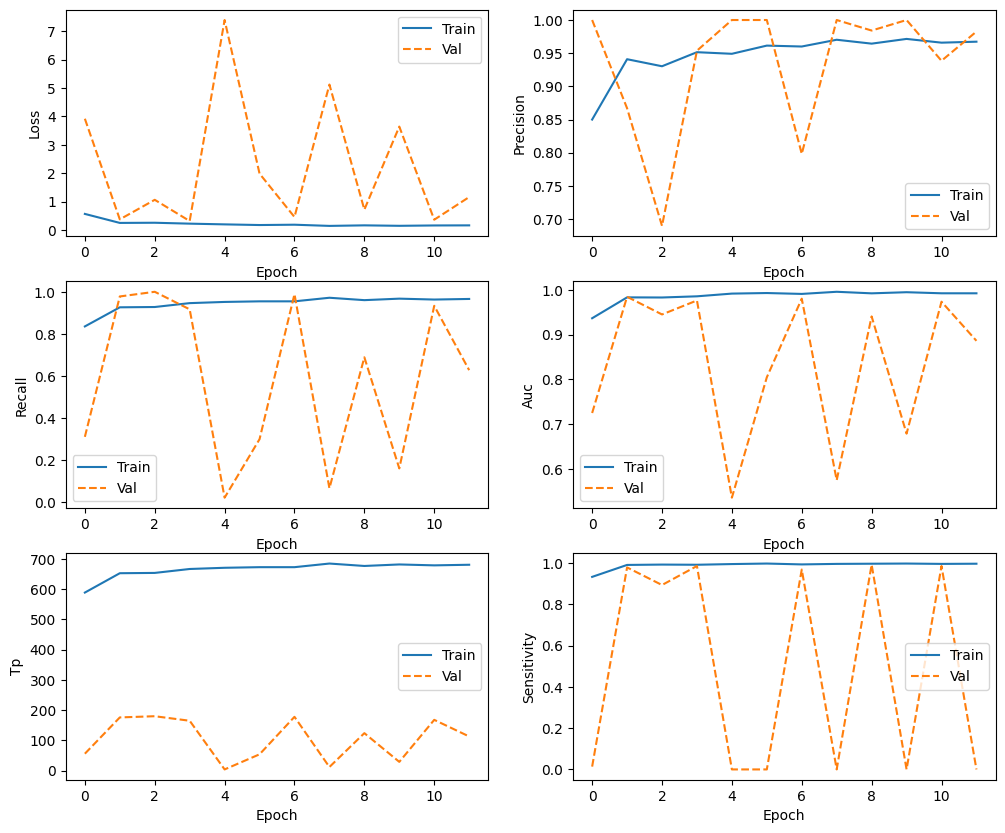

In [ ]:
# Function to plot performance metrics
def plot_metrics(history):
    metrics = ['loss', 'precision', 'recall', 'auc', 'tp', 'sensitivity']
    plt.figure(figsize=(12, 10))
    for n, metric in enumerate(metrics):
        plt.subplot(3, 2, n+1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_' + metric], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
    plt.show()

plot_metrics(history)


In [ ]:
# Evaluate model on test data
print("Evaluate on test data")
score_test = model.evaluate(test_ds)
for name, value in zip(model.metrics_names, score_test):
  print(name, ':', value)


Evaluate on test data
20/20 ━━━━━━━━━━━━━━━━━━━━ 97s 5s/step - accuracy: 0.7091 - auc: 0.6813 - fn: 2.4762 - fp: 97.6190 - loss: 3.7150 - precision: 0.6811 - recall: 0.9894 - sensitivity: 0.3957 - tn: 37.0952 - tp: 212.5238
loss : 3.2286696434020996
compile_metrics : 386.0


In [ ]:
# Evaluate model on test data
print("Evaluate on test data")
score_test = model.evaluate(test_ds)
ffor name, value in zip(model.metrics_names, score_test):
    print(name, ':', value)

In [ ]:
import numpy as np
y_test = np.concatenate([y.numpy() for _, y in test_ds])  # Extract true labels

In [ ]:
y_train = np.concatenate([y.numpy() for _, y in train_ds])  # Extract labels


In [ ]:
y_test_pred = model.predict(test_ds)  # Get predictions


20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 733ms/step


In [ ]:
y_train_pred = model.predict(train_ds)  # Get predictio

30/30 ━━━━━━━━━━━━━━━━━━━━ 55s 912ms/step


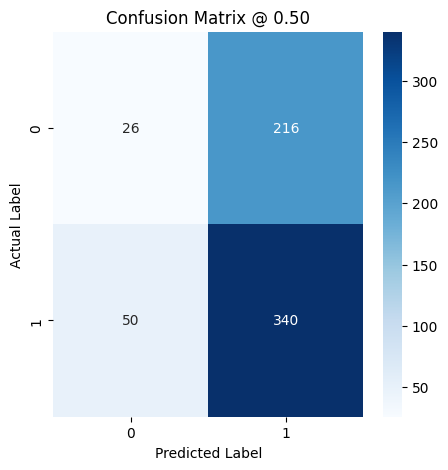

True Negatives: 26
False Positives: 216
False Negatives: 50
True Positives: 340
Total Positives: 390


In [ ]:
# Function to plot confusion matrix
def plot_cm(labels, predictions, threshold=0.5):
    cm = confusion_matrix(labels, predictions > threshold)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix @ {threshold:.2f}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print('True Negatives:', cm[0][0])
    print('False Positives:', cm[0][1])
    print('False Negatives:', cm[1][0])
    print('True Positives:', cm[1][1])
    print('Total Positives:', np.sum(cm[1]))

plot_cm(y_test, y_test_pred)

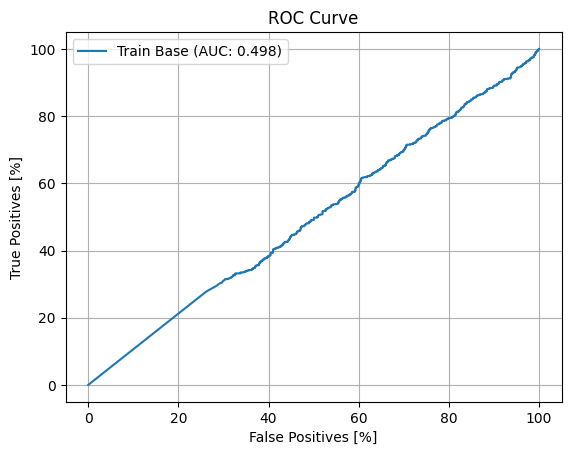

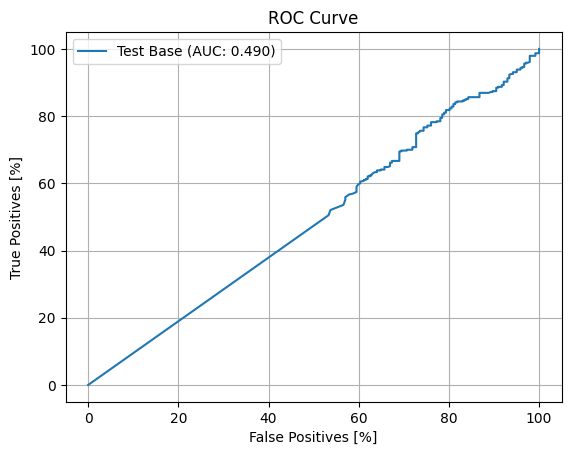

In [ ]:
# Function to plot ROC curve
def plot_roc(name, labels, predictions):
    fp, tp, _ = roc_curve(labels, predictions)
    auc_score = roc_auc_score(labels, predictions)
    plt.plot(fp * 100, tp * 100, label=f'{name} (AUC: {auc_score:.3f})')
    plt.xlabel('False Positives [%]')
    plt.ylabel('True Positives [%]')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_roc("Train Base", y_train, y_train_pred)
plot_roc("Test Base", y_test, y_test_pred)
